# Assignment 1: Human Activity Recognition

Authors:  
Lorenzo Lucchini


## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import tensorflow as tf
import xgboost as xgb

import warnings 
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix



## Load data

I will create single file with clean data, this will done by merging of all the subjects from the downloaded data and removing the exercises with code 0, no furhtermore actions seem to be required as the provided data set is stated to have no null values.

I'll start by renaming the columns and joining the data data files into a single file.

In [3]:
combined_df = pd.DataFrame()

# Merge all subject into a single one
for i in range(1, 11):
    df = pd.read_csv(f'../MHEALTHDATASET/mHealth_subject{i}.log', header=None, sep='\t')
    df = df.loc[:, [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]].rename(columns= {
        0: 'chest_acc_x', 
        1: 'chest_acc_y', 
        2: 'chest_acc_z',
        3: 'elect_si_1',
        4: 'elect_si_1',
        5: 'lank_acc__x', 
        6: 'lank_acc__y',
        7: 'lank_acc__z', 
        8: 'lank_gyr_x',
        9: 'lank_gyr_y', 
        10: 'lank_gyr_z', 
        11: 'mag_lank_x', 
        12: 'mag_lank_y', 
        13: 'mag_lank_z', 
        14: 'rlowarm_acc_x', 
        15: 'rlowarm_acc_y',
        16: 'rlowarm_acc_z', 
        17: 'rlowarm_gyr_x', 
        18: 'rlowarm_gyr_y', 
        19: 'rlowarm_gyr_z', 
        20: 'mag_rlowarm_x', 
        21: 'mag_rlowarm_y', 
        22: 'mag_rlowarm_z',
        23: 'activity'
    })
    df['subject'] = f'subject{i}'
    combined_df = pd.concat([combined_df, df])

combined_df.to_csv('ProcessedData/allActivityMerged.csv', index=False)

the activity codes are:

L1: Standing still (1 min)

L2: Sitting and relaxing (1 min) 

L3: Lying down (1 min) 

L4: Walking (1 min) 

L5: Climbing stairs (1 min) 

L6: Waist bends forward (20x) 

L7: Frontal elevation of arms (20x)

L8: Knees bending (crouching) (20x)

L9: Cycling (1 min)

L10: Jogging (1 min)

L11: Running (1 min)

L12: Jump front & back (20x)

Since I'm assuming that code 0 for activity doesn't have an impact in the prediction of the activities as required by the task (as it doesnt have an activity label), I will also create a new file with only activities with values from 1 to 12

In [4]:

# Remove rows where 'activity' column has value 0
filteredActivity_df = combined_df[combined_df['activity'] != 0]


filteredActivity_df.to_csv('ProcessedData/filteredActivityMerged.csv', index=False)

## Data Visualization

Visualize the data to identify possible changes required

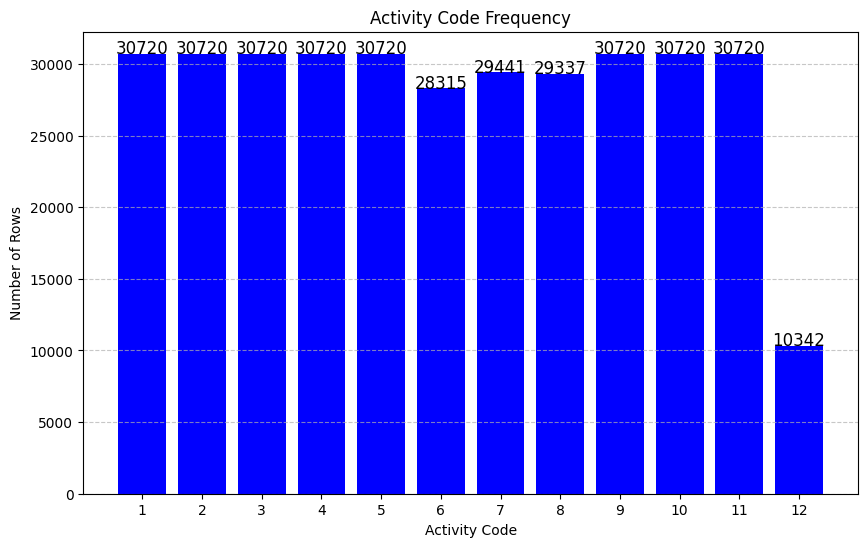

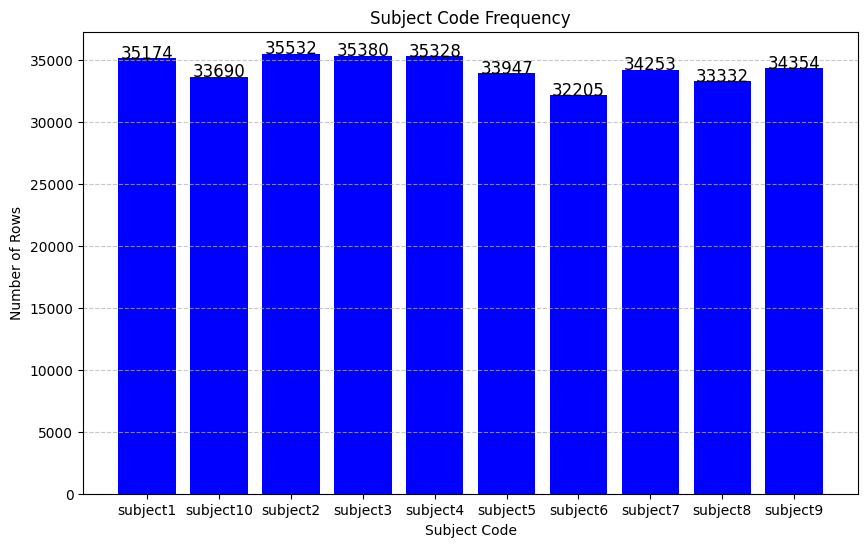

In [5]:
def plot_activity_counts(df):
    
    # Count occurrences of each activity code
    activity_counts = df['activity'].value_counts().sort_index()
    
    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(activity_counts.index, activity_counts.values, color='blue')
    plt.xlabel('Activity Code')
    plt.ylabel('Number of Rows')
    plt.title('Activity Code Frequency')
    plt.xticks(activity_counts.index)  # Ensure all activity codes are displayed
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Display the values on top of the bars
    for index, value in enumerate(activity_counts.values):
        plt.text(activity_counts.index[index], value + 0.1, str(value), ha='center', fontsize=12)
    plt.show()

def plot_subject_counts(df):
   
    # Count occurrences of each activity code
    subject_counts = df['subject'].value_counts().sort_index()
    
    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(subject_counts.index, subject_counts.values, color='blue')
    plt.xlabel('Subject Code')
    plt.ylabel('Number of Rows')
    plt.title('Subject Code Frequency')
    plt.xticks(subject_counts.index)  # Ensure all activity codes are displayed
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Display the values on top of the bars
    for index, value in enumerate(subject_counts.values):
        plt.text(subject_counts.index[index], value + 0.1, str(value), ha='center', fontsize=12)
    plt.show()

# Load data from file
df_display = pd.read_csv('ProcessedData/filteredActivityMerged.csv')

plot_activity_counts(df_display)
plot_subject_counts(df_display)



Lets start to check for correlation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343195 entries, 0 to 343194
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   chest_acc_y    343195 non-null  float64
 1   chest_acc_z    343195 non-null  float64
 2   lank_acc__x    343195 non-null  float64
 3   lank_acc__y    343195 non-null  float64
 4   lank_acc__z    343195 non-null  float64
 5   lank_gyr_x     343195 non-null  float64
 6   lank_gyr_y     343195 non-null  float64
 7   lank_gyr_z     343195 non-null  float64
 8   mag_lank_x     343195 non-null  float64
 9   mag_lank_y     343195 non-null  float64
 10  mag_lank_z     343195 non-null  float64
 11  rlowarm_acc_x  343195 non-null  float64
 12  rlowarm_acc_y  343195 non-null  float64
 13  rlowarm_acc_z  343195 non-null  float64
 14  rlowarm_gyr_x  343195 non-null  float64
 15  rlowarm_gyr_y  343195 non-null  float64
 16  rlowarm_gyr_z  343195 non-null  float64
 17  mag_rlowarm_x  343195 non-nul

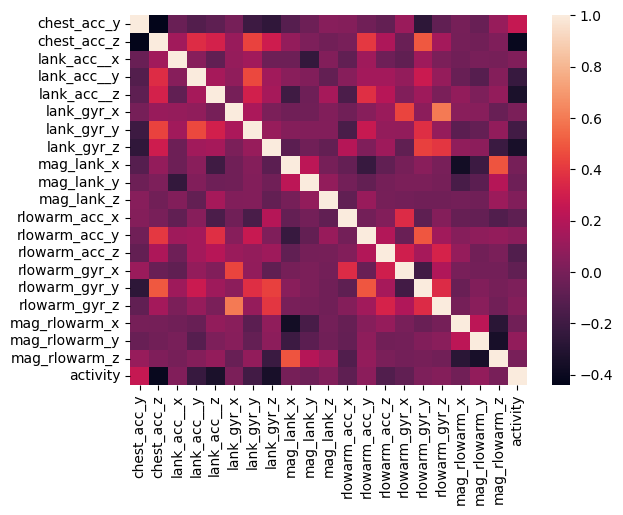

In [6]:
data = pd.read_csv('ProcessedData/filteredActivityMerged.csv')

data = data.iloc[:,1:-1]
data.info()
label_encoder = LabelEncoder()
data.iloc[:,0] = label_encoder.fit_transform(data.iloc[:,0]).astype('float64')

corr = data.corr()
sns.heatmap(corr)


columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = data.columns[columns]
data_corr = data[selected_columns]
data_corr.info()

After checking for sampling and correlation, the columns seem to be un correlated. However the sampling size sees a large difference for activity type but similar sampling for subject. I will therefore create an oversampling for activities 6, 7, 8, and 12

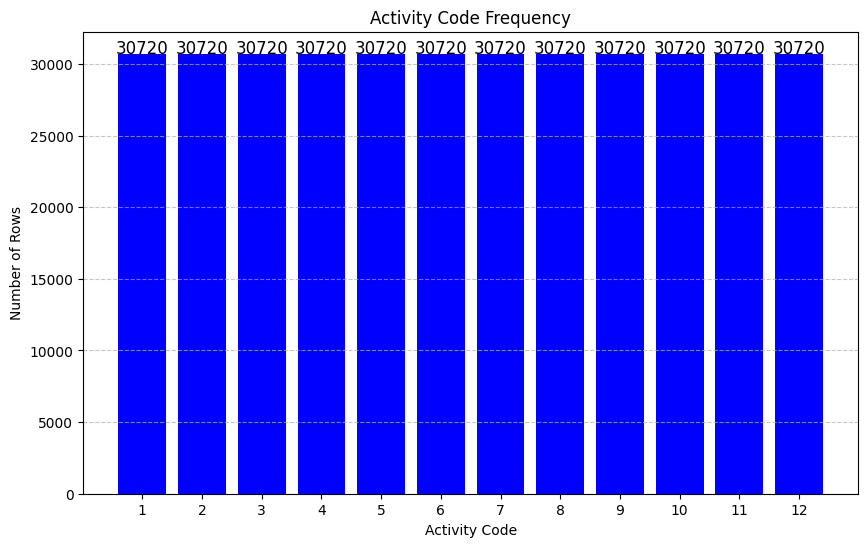

In [7]:
# Load dataset
filteredData_df = pd.read_csv('ProcessedData/filteredActivityMerged.csv')

fullActivityMerged_df = filteredData_df.drop(columns=['subject'])

fullActivityMerged_df.to_csv('ProcessedData/fullActivityMerged.csv', index=False)


# Separate features and target
X = filteredData_df.drop(columns=['activity'])  # Features
y = filteredData_df['activity']  # Target (activity)

# Define the sampling strategy
# Only upsample activities 0, 6, 7, and 8 to 30,720 samples, keeping others unchanged
target_counts = {label: count for label, count in Counter(y).items()}  # Keep existing counts
for target_class in [6, 7, 8, 12]:
    if target_counts.get(target_class, 0) < 30720:  # Only oversample if needed
        target_counts[target_class] = 30720

# Apply RandomOverSampler
ros = RandomOverSampler(sampling_strategy=target_counts, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)


# Create new DataFrame with resampled data
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['activity'] = y_resampled

df_resampled = df_resampled.drop(columns=['subject'])

# Save the new balanced dataset
df_resampled.to_csv('ProcessedData/oversampledActivityMerged.csv', index=False)

plot_activity_counts(df_resampled)


Since the use of oversampling might cuase overfitting I will have to keep this in mind during the model training.
Now we have a clean data set that can be used to start training the chosen models.

In [8]:
print("The file contains: " + str(len(df_display))+ " rows")

The file contains: 343195 rows


Since the file of data produced contains more then 300 000 rows, the data set is quite large. Furthermore the goal of our task is to achive classification of movement. Also the data is a structured tabular data. For these reasons, according to what we have learned during the lectures the best model should be:  XGBoost, another good fit for this model could be random forest, and finally I might try to create an ensamble model and see if there are any important differences.

## Task 1 Prediction

### Develop a model that can accurately predict the activity based on features. If you use multiple models, report the accuracy (or other relevant score) for all models and motivate which model works best. Note that different models might work better for different activities. This motivates steps 2 and 3.
### I'll be using MHEALTH dataset: classes are the activities

### Splitting data set and Model definitions

As stated before my data set is vulnerable to overfitting, and I will therefore use the k-fold validation method to try and avoid this as much as possible. 

In [9]:
# Split features and target
final_df = pd.read_csv("ProcessedData/oversampledActivityMerged.csv")
X = final_df.drop(columns=["activity"])  
y = final_df["activity"]
y = y - 1 # I need to do this as the XGBClassifier expects a starting index of 0 and i have it at 1

# Split into train and test sets I chose 20 percent test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#I will no use kfold to split the training data into validation as well
kf = KFold(n_splits=4, shuffle=True, random_state=42)


The first Model I will test is  XGBoost, i will save the model produced in the Models folder

Training XGBoost with max_depth=2 using 4-Fold CV...
Max Depth: 2 | Mean Accuracy: 0.8723
Training XGBoost with max_depth=3 using 4-Fold CV...
Max Depth: 3 | Mean Accuracy: 0.9240
Training XGBoost with max_depth=4 using 4-Fold CV...
Max Depth: 4 | Mean Accuracy: 0.9515
Training XGBoost with max_depth=5 using 4-Fold CV...
Max Depth: 5 | Mean Accuracy: 0.9713
Training XGBoost with max_depth=6 using 4-Fold CV...
Max Depth: 6 | Mean Accuracy: 0.9831
Training XGBoost with max_depth=7 using 4-Fold CV...
Max Depth: 7 | Mean Accuracy: 0.9895
Training XGBoost with max_depth=8 using 4-Fold CV...
Max Depth: 8 | Mean Accuracy: 0.9930
Training XGBoost with max_depth=9 using 4-Fold CV...
Max Depth: 9 | Mean Accuracy: 0.9950


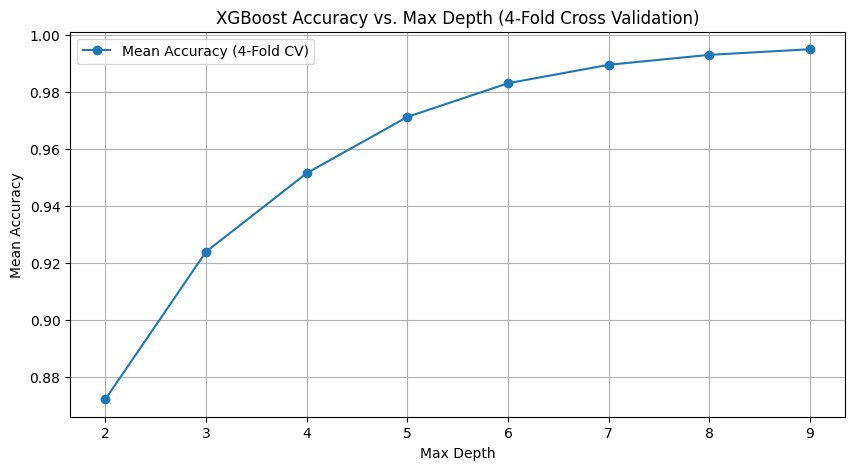

Best max_depth found: 9


In [10]:
depth_scores = []

# Loop through different max_depth values (from 2 to 8)
for i in range(2, 10):
    print(f"Training XGBoost with max_depth={i} using 4-Fold CV...")

   # Define the XGBoost model with regularization
    xgb_model = xgb.XGBClassifier(
        max_depth=i,  # Reduce complexity
        n_estimators=100,  # Lower number of trees
        learning_rate=0.05,  # Slower learning for better generalization
        subsample=0.8,  # Prevents overfitting
        colsample_bytree=0.8,  # Prevents reliance on a single feature
        reg_alpha=0.1,  # L1 Regularization (Lasso)
        reg_lambda=0.1,  # L2 Regularization (Ridge)
        random_state=42,
        use_label_encoder=False,
        eval_metric="mlogloss"
    )

    
    # Perform 4-fold cross-validation
    scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring="accuracy")

    # Store depth and mean accuracy
    depth_scores.append((i, scores.mean()))
    
    print(f"Max Depth: {i} | Mean Accuracy: {scores.mean():.4f}")

# Convert results to DataFrame
df_depth = pd.DataFrame(depth_scores, columns=["max_depth", "accuracy"])

# Plot Accuracy vs. Max Depth
plt.figure(figsize=(10, 5))
plt.plot(df_depth["max_depth"], df_depth["accuracy"], marker="o", linestyle="-", label="Mean Accuracy (4-Fold CV)")
plt.xlabel("Max Depth")
plt.ylabel("Mean Accuracy")
plt.title("XGBoost Accuracy vs. Max Depth (4-Fold Cross Validation)")
plt.legend()
plt.grid(True)
plt.show()

# Find the best max_depth
best_depth = df_depth.loc[df_depth["accuracy"].idxmax(), "max_depth"]
print(f"Best max_depth found: {best_depth}")

Even though the best max_depth found was 9, it is also true that the risk of overfitting is too high at that depth. For this reason i chose to go with a max depth of 4, as a score above 90% is extremely good and the increase of accuracy from 4 to 5 doesnt seem to be needed.

In [11]:
# Create the final model of xgb
final_xgb = xgb.XGBClassifier(
    max_depth=4,  # Reduce complexity
    n_estimators=100,  # Lower number of trees
    learning_rate=0.05,  # Slower learning for better generalization
    subsample=0.8,  # Prevents overfitting
    colsample_bytree=0.8,  # Prevents reliance on a single feature
    reg_alpha=0.1,  # L1 Regularization (Lasso)
    reg_lambda=0.1,  # L2 Regularization (Ridge)
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss"
)

# Train on full training data
final_xgb.fit(X_train, y_train)

# Predict on test data
y_xgb_pred_test = final_xgb.predict(X_test)

# Evaluate final model performance
xgb_test_accuracy = accuracy_score(y_test, y_xgb_pred_test)


In [13]:
print(xgb_test_accuracy)

0.9521620008680556


The value 0.95 seems to be an overfitting. In fact I chose to use oversampling to bring the activity 12 on pair with all other activities, so i want to make sure that is not the reason for the overfitting. To do this I will also train the same model on the orginal set without oversampling and compare the results with a function created with deepseek

In [15]:
# Load Original Dataset (Before Oversampling)
df_original = pd.read_csv("ProcessedData/fullActivityMerged.csv")

# Load Oversampled Dataset
df_oversampled = pd.read_csv("ProcessedData/oversampledActivityMerged.csv")

# Prepare Features & Labels for Both Datasets
X_original = df_original.drop(columns=["activity"])
y_original = df_original["activity"] - 1  # Shift labels to start from 0

X_oversampled = df_oversampled.drop(columns=["activity"])
y_oversampled = df_oversampled["activity"] - 1  # Shift labels to start from 0

# Split Data (Original)
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    X_original, y_original, test_size=0.2, stratify=y_original, random_state=42
)

# Split Data (Oversampled)
X_train_oversampled, X_test_oversampled, y_train_oversampled, y_test_oversampled = train_test_split(
    X_oversampled, y_oversampled, test_size=0.2, stratify=y_oversampled, random_state=42
)

# Initialize XGBoost Model
xgb_params = {
    "max_depth": 4,
    "n_estimators": 100,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "reg_alpha":0.1,  # L1 Regularization (Lasso)
    "reg_lambda":0.1,  # L2 Regularization (Ridge)
    "use_label_encoder": False,
    "eval_metric": "mlogloss"
}

# Train on Original Data
xgb_original = xgb.XGBClassifier(**xgb_params)
xgb_original.fit(X_train_original, y_train_original)

# Train on Oversampled Data
xgb_oversampled = xgb.XGBClassifier(**xgb_params)
xgb_oversampled.fit(X_train_oversampled, y_train_oversampled)

# Predictions on Test Sets
y_pred_original = xgb_original.predict(X_test_original)
y_pred_oversampled = xgb_oversampled.predict(X_test_oversampled)

# Accuracy Comparison
train_acc_original = accuracy_score(y_train_original, xgb_original.predict(X_train_original))
test_acc_original = accuracy_score(y_test_original, y_pred_original)

train_acc_oversampled = accuracy_score(y_train_oversampled, xgb_oversampled.predict(X_train_oversampled))
test_acc_oversampled = accuracy_score(y_test_oversampled, y_pred_oversampled)

print(f"\n🔹 Train & Test Accuracy (Original Data)")
print(f"Train Accuracy (Before Oversampling): {train_acc_original:.4f}")
print(f"Test Accuracy (Before Oversampling): {test_acc_original:.4f}")

print(f"\n🔹 Train & Test Accuracy (Oversampled Data)")
print(f"Train Accuracy (After Oversampling): {train_acc_oversampled:.4f}")
print(f"Test Accuracy (After Oversampling): {test_acc_oversampled:.4f}")

# Check for Overfitting (Train vs Test Accuracy Difference)
overfitting_original = train_acc_original - test_acc_original
overfitting_oversampled = train_acc_oversampled - test_acc_oversampled

print(f"\n⚠️ Overfitting Difference (Original Data): {overfitting_original:.4f}")
print(f"⚠️ Overfitting Difference (Oversampled Data): {overfitting_oversampled:.4f}")

# F1-Score Comparison
print("\n🔹 Classification Report (Original Data):")
print(classification_report(y_test_original, y_pred_original))

print("\n🔹 Classification Report (Oversampled Data):")
print(classification_report(y_test_oversampled, y_pred_oversampled))


🔹 Train & Test Accuracy (Original Data)
Train Accuracy (Before Oversampling): 0.9542
Test Accuracy (Before Oversampling): 0.9533

🔹 Train & Test Accuracy (Oversampled Data)
Train Accuracy (After Oversampling): 0.9535
Test Accuracy (After Oversampling): 0.9522

⚠️ Overfitting Difference (Original Data): 0.0008
⚠️ Overfitting Difference (Oversampled Data): 0.0013

🔹 Classification Report (Original Data):
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      6144
           1       1.00      1.00      1.00      6144
           2       1.00      1.00      1.00      6144
           3       0.94      0.97      0.96      6144
           4       0.95      0.89      0.92      6144
           5       0.94      0.95      0.95      5663
           6       0.97      0.97      0.97      5888
           7       0.91      0.92      0.92      5868
           8       1.00      1.00      1.00      6144
           9       0.92      0.88      0.90      614

The 
⚠️ Overfitting Difference (Original Data): 0.0008
⚠️ Overfitting Difference (Oversampled Data): 0.0013
seems to display that there is very little overfitting difference in the two models, and that the model seems to be extremely accurate.
I will therefore save this model to the models folder

In [16]:
joblib.dump(final_xgb, "Models/xgboost_model.pkl")

['Models/xgboost_model.pkl']

The second Model I will test is the RandomForestClassifier, i will mantain the same parameters as the xgboost to see how they compare


In [18]:
# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=4,  # Limit tree depth to prevent overfitting
    min_samples_split=5,  # Minimum samples required to split
    min_samples_leaf=2,  # Minimum samples in a leaf node
    random_state=42,
    n_jobs=-1  # Use all available cores for training
)

# Perform Cross-Validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring="accuracy")

# Print Cross-Validation Results
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean Accuracy across folds: {np.mean(cv_scores):.4f}")

Cross-validation accuracy scores: [0.7491862  0.74989149 0.74841309 0.74860297]
Mean Accuracy across folds: 0.7490


In [19]:
# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=9,  # Limit tree depth to prevent overfitting
    min_samples_split=5,  # Minimum samples required to split
    min_samples_leaf=2,  # Minimum samples in a leaf node
    random_state=42,
    n_jobs=-1  # Use all available cores for training
)

# Perform Cross-Validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring="accuracy")

# Print Cross-Validation Results
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean Accuracy across folds: {np.mean(cv_scores):.4f}")


Cross-validation accuracy scores: [0.924764   0.92351617 0.92671712 0.92538791]
Mean Accuracy across folds: 0.9251


The difference in accuracy is quite high, the random forest being much lower in the accuracy. In order to achive similar accuracy the randomforest classifier needs a depth of 9 which however is extremely prone to overfitting. I will therefore define the xgboost as the better model for this task.


In [19]:


# Train on full training data
rf_model.fit(X_train, y_train)

# Predict on test data
y_rf_pred_test = rf_model.predict(X_test)

# Evaluate final model performance
rf_test_accuracy = accuracy_score(y_test, y_rf_pred_test)

print(rf_test_accuracy)

0.92724609375


Now I will check if an ensable would make a difference 

In [20]:
# Define Random Forest Model
ensable_rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Define XGBoost Model
ensable_xgb_model = xgb.XGBClassifier(
    max_depth=3,
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    reg_alpha=0.1,  # L1 Regularization (Lasso)
    reg_lambda=0.1,  # L2 Regularization (Ridge)
    eval_metric="mlogloss"
)

# Create Voting Classifier with both models
ensemble_model = VotingClassifier(
    estimators=[('random_forest', ensable_rf_model), ('xgboost', ensable_xgb_model)],
    voting='soft'  # Use soft voting (probabilities) for better accuracy
)

cv_scores = cross_val_score(ensemble_model, X_train, y_train, cv=kf, scoring="accuracy")

# Print Cross-Validation Results
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean Accuracy across folds: {np.mean(cv_scores):.4f}")



# Train on full training data
ensemble_model.fit(X_train, y_train)

# Predict on test data
y_ensable_pred_test = ensemble_model.predict(X_test)

# Evaluate final model performance
ensamble_test_accuracy = accuracy_score(y_test, y_ensable_pred_test)

Cross-validation accuracy scores: [0.95521376 0.95487467 0.95376248 0.95479329]
Mean Accuracy across folds: 0.9547


In [21]:
print(ensamble_test_accuracy)

0.9553493923611112


The added complexity of ensable create a 0.3 increase in accuracy of movement classification in the model, if we analise the confusion matrix:

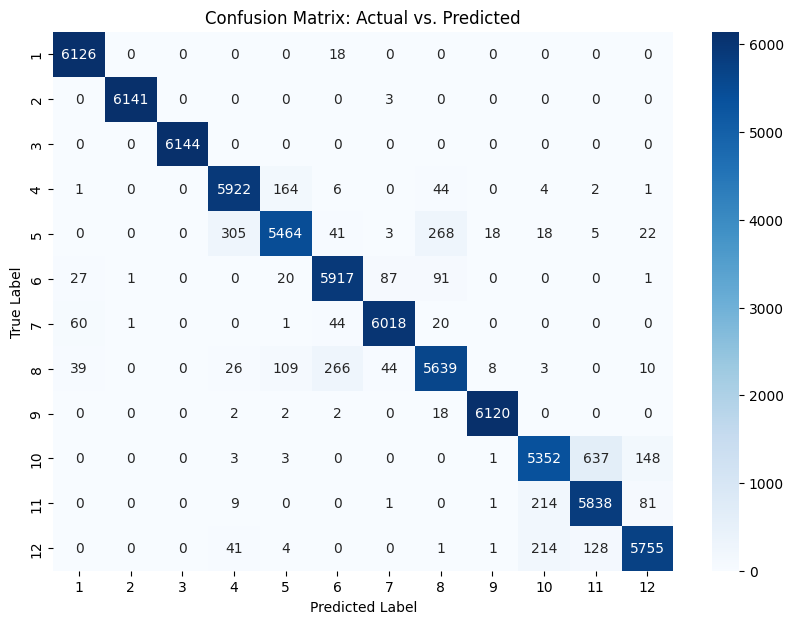

In [22]:
cm = confusion_matrix(y_test, y_ensable_pred_test)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 13), yticklabels=range(1, 13))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Actual vs. Predicted")
plt.show()

we can see that the distribution seems to be quite great except for activities 5 and 8, with a slight alteration in 10 11 and 12.
The slight alteration seems therefore being in high intesinty activity, where jogging(10) gets interchanged for running(11), this makes a lot of sense as the only difference between the two is the running speed.
For the main error between climbing stars (5) and knees bending(8), this two activies share a lot of movement similarities to other activities so it makes sense that they would be classified with more confusion.

The model could be further optimised with a gradient boosting. But for now it seems to be great at it's classification.

In [23]:
joblib.dump(ensemble_model, "Models/ensemble_model.pkl")

['Models/ensemble_model.pkl']

## Task 2 Feature Engineering:

 Identify the minimal set of features (you might need to create or estimate other features from the dataset) that can predict each activity. You might find that different features predict different activities. 

Since the model I chose is the ensamble model I will have to first calculate which of the 21 feautures are the features mostly used in the xgb and rf models used in the ensamble, after which I can start removing features while the prediction accuracy doesnt vastly decrease.

[0.05257424 0.01463705 0.10181616 0.04029425 0.06850094 0.07041667
 0.02460726 0.0373022  0.03703301 0.04167759 0.02304946 0.02771057
 0.06972448 0.06743409 0.06734252 0.05262713 0.04573032 0.03939087
 0.0414321  0.03919216 0.03750702]


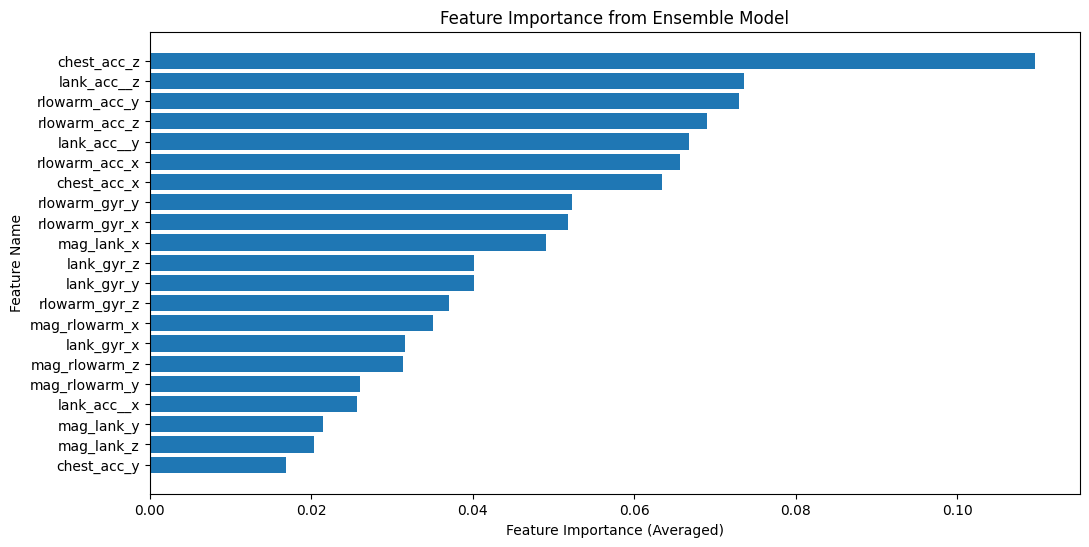

In [27]:
# Extract feature importance from XGBoost
xgb_importance = final_xgb.feature_importances_

# Extract feature importance from Random Forest
rf_importance = rf_model.feature_importances_


# Compute average feature importance
avg_importance = (xgb_importance + rf_importance) / 2


# Create a DataFrame for visualization
improtance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'XGBoost Importance': xgb_importance,
    'Random Forest Importance': rf_importance,
    'Average Importance': avg_importance
}).sort_values(by="Average Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(improtance_df['Feature'], improtance_df['Average Importance'])
plt.xlabel("Feature Importance (Averaged)")
plt.ylabel("Feature Name")
plt.title("Feature Importance from Ensemble Model")
plt.gca().invert_yaxis()  # Reverse order for better readability
plt.show()



I will now create a new model containing the learning based on number of features to identify the breaking point for the minimum number of features for the prediction.

Features: 7 | Accuracy: 0.8263
Features: 8 | Accuracy: 0.8443
Features: 9 | Accuracy: 0.8754
Features: 10 | Accuracy: 0.9003
Features: 11 | Accuracy: 0.9072
Features: 12 | Accuracy: 0.9140
Features: 13 | Accuracy: 0.9220
Features: 14 | Accuracy: 0.9288
Features: 15 | Accuracy: 0.9358
Features: 16 | Accuracy: 0.9423


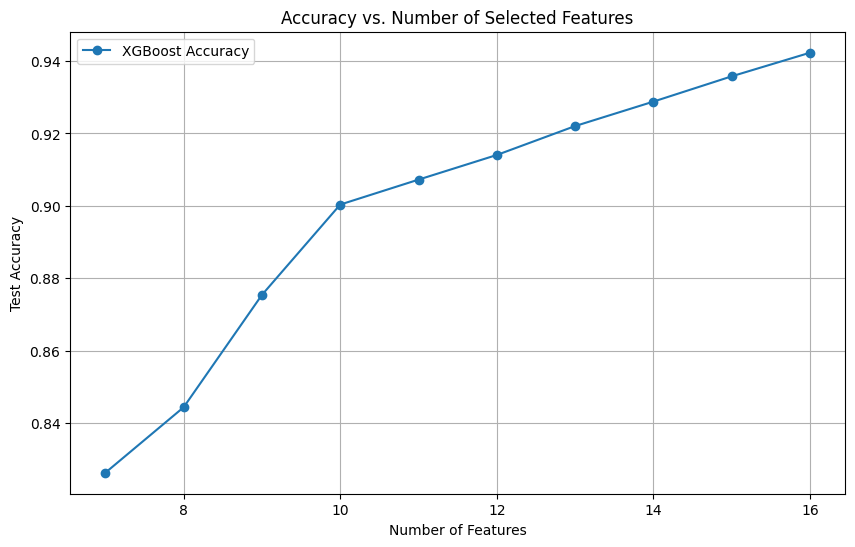

In [33]:
# Compute Feature Importance from XGBoost Model
xgb_full = xgb.XGBClassifier(
    n_estimators=100, 
    learning_rate=0.05, 
    max_depth=6, 
    random_state=42, 
    use_label_encoder=False, 
    eval_metric="mlogloss"
    )

xgb_full.fit(X_train, y_train)

# Extract Feature Importance
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": xgb_full.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Compare Accuracy from 7 to 16 Features
feature_range = range(7, 17)  # Features from 7 to 16
accuracy_results = []

for num_features in feature_range:
    # Select the top `num_features`
    selected_features = importance_df["Feature"].head(num_features)
    
    # Train with selected features
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    
    xgb_selected = xgb.XGBClassifier(
        max_depth=4,  
        n_estimators=100,
        learning_rate=0.05,  
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,  
        reg_lambda=0.1,  
        random_state=42,
        use_label_encoder=False,
        eval_metric="mlogloss"
    )
    
    xgb_selected.fit(X_train_selected, y_train)
    
    # Predict and evaluate accuracy
    y_pred_selected = xgb_selected.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred_selected)
    
    accuracy_results.append((num_features, accuracy))
    print(f"Features: {num_features} | Accuracy: {accuracy:.4f}")

# Convert results to DataFrame
accuracy_df = pd.DataFrame(accuracy_results, columns=["Num_Features", "Accuracy"])

# Plot Accuracy vs. Number of Features
plt.figure(figsize=(10, 6))
plt.plot(accuracy_df["Num_Features"], accuracy_df["Accuracy"], marker="o", linestyle="-", label="XGBoost Accuracy")
plt.xlabel("Number of Features")
plt.ylabel("Test Accuracy")
plt.title("Accuracy vs. Number of Selected Features")
plt.legend()
plt.grid(True)
plt.show()

The highest change in the accuracy of the model seems to be from 10 to 9 features. I will therefore retrain my ensable with 10 feauteres and check it's performance based on accuracy and confusion matrix

2       chest_acc_z
13    rlowarm_acc_y
12    rlowarm_acc_x
5       lank_acc__z
4       lank_acc__y
15    rlowarm_gyr_x
0       chest_acc_x
14    rlowarm_acc_z
16    rlowarm_gyr_y
9        mag_lank_x
Name: Feature, dtype: object
0.9042697482638888


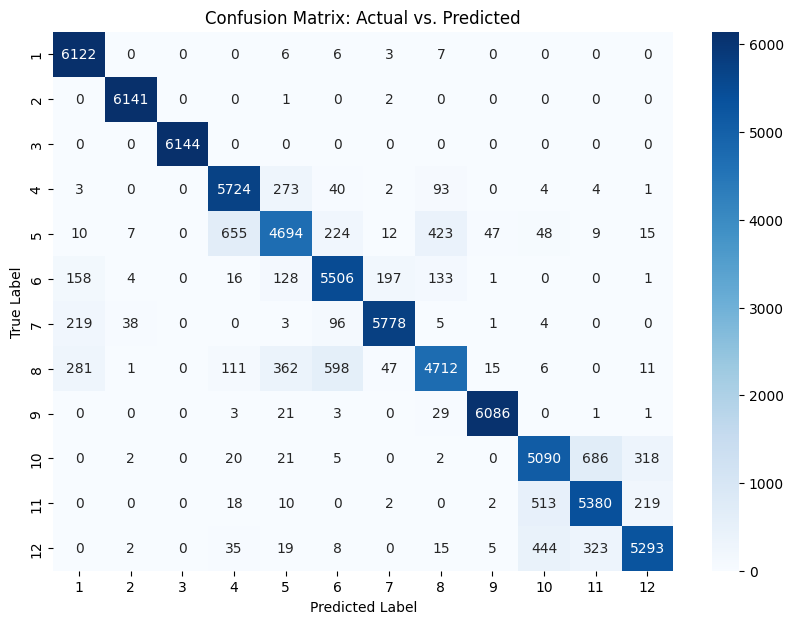

In [36]:

# Create Voting Classifier with both models
minimal_ensemble_model = VotingClassifier(
    estimators=[('random_forest', ensable_rf_model), ('xgboost', ensable_xgb_model)],
    voting='soft'  # Use soft voting (probabilities) for better accuracy
)
top_selected_features = importance_df["Feature"].head(10)
print(top_selected_features)

X_test_selected_10 = X_test[top_selected_features]
X_train_selected_10 = X_train[top_selected_features]

# Train ensemble on selected features
minimal_ensemble_model.fit(X_train_selected_10, y_train)

# Predict on test data
y_minimal_nsable_pred_test = minimal_ensemble_model.predict(X_test_selected_10)

# Evaluate final model performance
minimal_ensamble_test_accuracy = accuracy_score(y_test, y_minimal_nsable_pred_test)

print(minimal_ensamble_test_accuracy)

cm = confusion_matrix(y_test, y_minimal_nsable_pred_test)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 13), yticklabels=range(1, 13))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Actual vs. Predicted")
plt.show()


## Results and Discussion

This section should contain:
- Results.
- Summary of best model performance:
    - Name of best model file as saved in /models.
    - Relevant scores such as: accuracy, precision, recall, F1-score, etc.
- Key discussion points.

In [ ]:
# Always use comments in the code to document specific steps